In [21]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import os
from PIL import Image
import numpy as np

In [22]:
root = "fer"
batch_size = 30
num_workers = 0

transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

training = ImageFolder(root + "/train",transform=transform)
test = ImageFolder(root + "/test",transform=transform)

train_loader = torch.utils.data.DataLoader(training, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [28]:
import torch.nn as nn
import torch.nn.functional as F
class EmotionCNN(torch.nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)

        self.maxpool = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 256, 3)

        self.fc1 = nn.Linear(12544, 1024)
        self.fc2 = nn.Linear(1024, 7)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))        
        x = self.maxpool(x)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        return F.softmax(self.fc2(x))
        
        

In [29]:
model = EmotionCNN()
model.cuda()

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [30]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters())

<IPython.core.display.Javascript object>


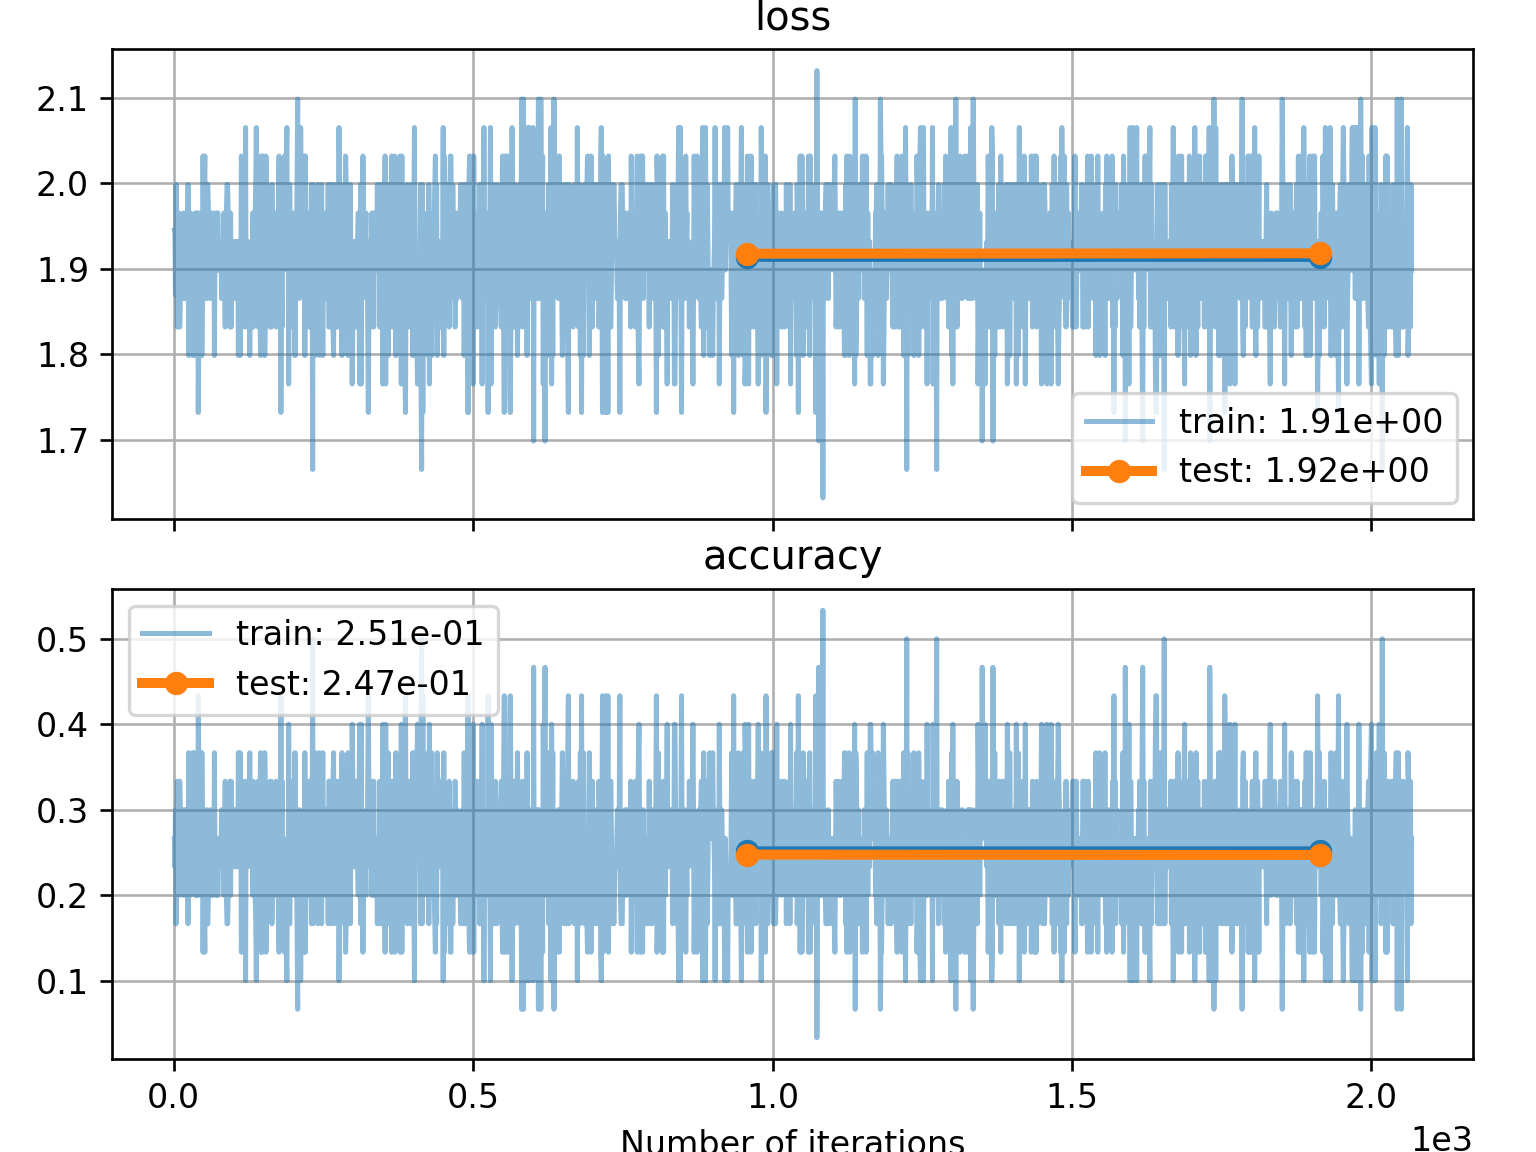

In [31]:
from noggin import create_plot
%matplotlib notebook
plotter, figs, axes = create_plot(metrics=["loss", "accuracy"])

In [32]:
# number of epochs to train the model
n_epochs = 20

test_loss_min = np.Inf # track change in test loss

for epoch in range(n_epochs):

    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    counter = 0
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        prediction = torch.argmax(output, dim=1)
        acc = torch.mean((prediction == target).type(torch.DoubleTensor))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
        counter += 1
        
    ######################    
    # test the model #
    ######################
    model.eval()
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        prediction = torch.argmax(output, dim=1)
        acc = torch.mean((prediction == target).type(torch.DoubleTensor))
        # update average test loss 
        test_loss += loss.item()*data.size(0)

        plotter.set_test_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    test_loss = test_loss/len(test_loader.sampler)
        
    # print training/test statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, test_loss))
    
    # save model if test loss has decreased
    if train_loss <= test_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        test_loss))
        torch.save(model.state_dict(), 'emotion_model_new.pt')
        test_loss_min = test_loss
    
    plotter.set_train_epoch()
    plotter.set_test_epoch()

C:\Users\andre\Anaconda3\envs\friend.ly\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 	Training Loss: 1.914169 	Validation Loss: 1.918277
Validation loss decreased (inf --> 1.918277).  Saving model ...
Epoch: 1 	Training Loss: 1.914107 	Validation Loss: 1.918277
Validation loss decreased (1.918277 --> 1.918277).  Saving model ...


KeyboardInterrupt: 